In [1]:
import xarray as xr
# import matplotlib.pyplot as plt
import datetime
from glob import glob
import dask, dask.distributed
import dask_jobqueue
import matplotlib.pyplot as plt
import datetime
import numpy as np
# import parcels
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import cartopy.crs as ccrs
import cmocean
from xhistogram.xarray import histogram as xhist
import seawater as gsw
import matplotlib.colors as mcolors
import datetime as dt 

In [2]:
cluster = dask_jobqueue.SLURMCluster(

    # Dask worker size
    cores=4, memory='16GB',
    processes=1, # Dask workers per job
    
    # SLURM job script things
    queue='base', walltime='04:00:00',
    
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',  # for spilling tmp data to disk
    log_directory='slurm/' 
)

client = dask.distributed.Client(cluster)

cluster.scale(jobs=15) #15
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.18.4.22:35651/status,
Dashboard: http://172.18.4.22:35651/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.18.4.22:38421,Workers: 0
Dashboard: http://172.18.4.22:35651/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
import yaml
import os
outdir = 'data/level3/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
if os.path.exists(f'{outdir}/minmax.yaml'):
    with open(f'{outdir}/minmax.yaml', 'r') as file:
        results = yaml.load(file, Loader=yaml.FullLoader)
else:
    results = calc_min_max(ds)
    with open(f'{outdir}/minmax.yaml', 'w') as file:
        yaml.dump(results, file)

n=0.25
lon_bins = np.arange(results['lon_min'], results['lon_max'], n)
lat_bins = np.arange(results['lat_min'], results['lat_max'], n)

def rechunk_for_hist(var):
    return var.chunk({'trajectory': 50, 'obs': -1})


In [4]:
# load in snapshot velocity and mesh masks

U_snapshot = xr.open_dataset('../../Data/U/U_velocity_2010-06-30.nc')
V_snapshot = xr.open_dataset('../../Data/V/V_velocity_2010-06-30.nc')

m = 1#650
U_m = U_snapshot.vozocrtx.isel(time_counter=0).sel(deptht=m,method='nearest')
V_m = V_snapshot.vomecrty.isel(time_counter=0).sel(deptht=m,method='nearest')

speed_m = (U_m**2 + V_m**2)**.5

mesh_mask = xr.open_dataset('../../Data/mesh_masks/mesh_mask.nc')
mesh_hzgr = xr.open_dataset('../../Data/mesh_masks/mesh_hzgr.nc')
mesh_hgr = xr.open_dataset('../../Data/mesh_masks/mesh_hgr.nc')

z = mesh_hzgr.e3t_0
t_mask = mesh_mask.tmask

# bathymetry (Depth level) at every grid point 
bathymetry = (z*t_mask).isel(t=0).sum(dim='z')

# turn zeros into nans, easier to see where continents are 
bath_total_nans = bathymetry.where(bathymetry != 0)
land_mask = mesh_mask.tmask.where(mesh_mask.tmask!=0).isel(t=0,z=0)

In [26]:
def filter_beached_particles(ds,dim=None):
    """
    Filter particles in the dataset based on salinity.

    Parameters:
    ds (xarray.Dataset): The dataset containing salinity data.

    Returns:
    xarray.Dataset: A filtered dataset including only particles that have not reached zero salinity.
    """
    # Identify particles that reach zero salinity
    particles_reach_zero_salinity = (ds.salt == 0).any(dim)

    # Identify particles that have not reached zero salinity (beached)
    particles_beached = ~particles_reach_zero_salinity

    # Filter the dataset to include only particles that have not reached zero salinity
    ds_particles_reach_zero_salinity_beached = ds.where(particles_beached.compute(), drop=True)

    return ds_particles_reach_zero_salinity_beached

def compute_density(ds):
    ds_density = xr.apply_ufunc(gsw.eos80.pden,ds.salt,ds.temp,0,dask='parallelized',output_dtypes=[np.float64]) - 1000
    ds_add_dens = ds.assign(sigma0=ds_density)
    return ds_add_dens

def filter_particles_by_density(ds, density_threshold, dim=None):
    """
    Filter particles in the dataset based on a density threshold.

    Parameters:
    ds (xarray.Dataset): The input dataset containing particle density information.
    density_threshold (float): The density threshold for filtering particles (default is 28 kg/m³).

    Returns:
    xarray.Dataset: A dataset containing particles that exceed the specified density threshold.
    """
    # Identify particles with density less than the threshold
    particles_less_than_threshold = (ds.sigma0 < density_threshold).any(dim)
    
    # Identify particles that reach or exceed the threshold
    particles_that_reach_threshold = ~particles_less_than_threshold
    
    # Filter the dataset to include only particles that exceed the threshold
    ds_particles_greater_than_threshold = ds.where(particles_that_reach_threshold.compute(), drop=True)
    
    return ds_particles_greater_than_threshold



In [6]:
ds_orig = xr.open_dataset('data/level2/parcels_releases_seed-2345.zarr', engine='zarr', chunks='auto')
ds_orig = filter_beached_particles(ds_orig,'obs')
ds_orig = compute_density(ds_orig)

In [7]:


# Example usage:
ds_overflows = filter_particles_by_density(ds_orig,28, 'obs')


In [8]:
def define_sections(ds_orig):
    # Define the first section
    EIC = (ds_orig.lon > -15) & (ds_orig.lat > 66.25) & (ds_orig.lon < -11.95) & (ds_orig.lat < 68.7)
    Svinoy = (ds_orig.lon < 5.5) & (ds_orig.lat > 62.24) & (ds_orig.lon > -1) & (ds_orig.lat < 65)
    N_section = (ds_orig.lon > -6.0833 - 5) & (ds_orig.lat > 62.3333) & (ds_orig.lon < -6.0833 + 5) & (ds_orig.lat < 64.5)

    Svinoy_box = ds_orig.where(Svinoy, drop=False)
    EIC_box = ds_orig.where(EIC, drop=False)
    N_box = ds_orig.where(N_section, drop=False)
    total_domain_box = ds_orig.where((ds_orig.lon > -42) & (ds_orig.lat > 53) & (ds_orig.lon < 47) & (ds_orig.lat < 85), drop=False)

    sections = {
        'Svinoy_box': Svinoy_box,
        'EIC_box': EIC_box,
        'N_box': N_box,
        'total_domain_box': total_domain_box
    }
    return sections

# Call the function
sections = define_sections(ds_orig)
Svinoy_box, EIC_box, N_box, total_domain_box = sections['Svinoy_box'], sections['EIC_box'], sections['N_box'], sections['total_domain_box']


In [9]:
sections_overflows = define_sections(ds_overflows)
Svinoy_box_overflows, EIC_box_overflows, N_box_overflows, total_domain_box_overflows = sections_overflows['Svinoy_box'], sections_overflows['EIC_box'], sections_overflows['N_box'], sections_overflows['total_domain_box']

In [10]:
def calculate_slope_intercept(x1, y1, x2, y2):
    """Calculate the slope (m) and y-intercept (b) of a line."""
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return m, b

def process_section(key, ds_orig):
    """Process the specified section and return datasets based on the key."""
    
    dist = 0.4  # Distance used for calculations

    if key == 'Svinoy':
        box = Svinoy_box  # Use the Svinoy box
        m, b = calculate_slope_intercept(5.5, 62.24 - dist, -1, 65 - dist)
        m2, b2 = calculate_slope_intercept(5.5, 62.24 + dist, -1, 65 + dist)

        ds_window = box.lat >= box.lon * m + b
        ds_window2 = box.lat <= box.lon * m2 + b2
        ds_line_cross = (box.lat >= box.lon * m + b) & (box.lat <= box.lon * m2 + b2)

    elif key == 'EIC':
        box = EIC_box  # Use the EIC box
        m, b = calculate_slope_intercept(-15, 66.25 - dist, -11.95, 68.7 - dist)
        m2, b2 = calculate_slope_intercept(-15, 66.25 + dist, -11.95, 68.7 + dist)

        ds_window = box.lat >= box.lon * m + b
        ds_window2 = box.lat <= box.lon * m2 + b2
        ds_line_cross = (box.lat >= box.lon * m + b) & (box.lat <= box.lon * m2 + b2)

    elif key == 'N':
        box = N_box  # Use the N box
        ds_window = (box.lon <= -6.0833 + 0.1).astype(int)
        ds_window2 = (box.lon >= -6.0833 - 0.1).astype(int)
        ds_line_cross = (box.lon <= -6.0833 + 0.1) & (box.lon >= -6.0833 - 0.1).astype(int)

    else:
        raise ValueError("Invalid key provided. Please use 'Svinoy', 'EIC', or 'N'.")

    # Convert boolean arrays to integers
    ds_window = ds_window.astype(int)
    ds_window2 = ds_window2.astype(int)
    ds_line_cross = ds_line_cross.astype(int)

    # Create datasets based on the conditions
    ds_line = ds_orig.where(ds_window & ds_window2, drop=False)

    return {'ds_line': ds_line, 
            'line_cross': ds_line_cross}



In [11]:
# Example usage:
ds_Svinoy = process_section('Svinoy', ds_orig)['ds_line']
ds_EIC = process_section('EIC', ds_orig)['ds_line']
ds_N = process_section('N', ds_orig)['ds_line']


In [12]:
ds_Svinoy_overflows = process_section('Svinoy', ds_overflows)['ds_line']
ds_EIC_overflows = process_section('EIC', ds_overflows)['ds_line']
ds_N_overflows = process_section('N', ds_overflows)['ds_line']

In [13]:
def filter_trajectories(ds_line,ds_all_trajs):
    """
    Filters trajectories based on whether they cross the line.

    Parameters:
    ds_orig (xarray.Dataset): The original dataset containing trajectory data.
    ds_line (xarray.Dataset): The dataset containing the line information.

    Returns:
    traj_not_line (xarray.Dataset): Trajectories that do not cross the line.
    traj_line (xarray.Dataset): Trajectories that cross the line.
    traj_all (xarray.Dataset): All trajectories from the original dataset.
    """
    # Count the number of NaN values in the 'temp' variable across the 'obs' dimension
    nans_per_traj = (ds_line['temp'].isnull()).sum(dim='obs').compute()
    
    # Select trajectories based on the NaN count
    traj_not_line = ds_all_trajs.sel(trajectory=(nans_per_traj == ds_line.obs.size))  # select all trajs with all nans, i.e. not crossing
    traj_line = ds_all_trajs.sel(trajectory=(nans_per_traj != ds_line.obs.size))  # select all trajs with at least one non-nan, i.e. crossing
    
    # Return all trajectories
    traj_all = ds_all_trajs

    return {
        'traj_line': traj_line,
        'traj_not_line': traj_not_line,
        'traj_all': traj_all
    }


def compute_probability(traj_line_not_all):
    heat_map_obs_non = xhist(traj_line_not_all.lat, traj_line_not_all.lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="")
    heat_map_obs_unique_non = (heat_map_obs_non > 0).sum(dim='trajectory')
    heat_map_probability_non_cp = heat_map_obs_unique_non.compute()
    return heat_map_probability_non_cp

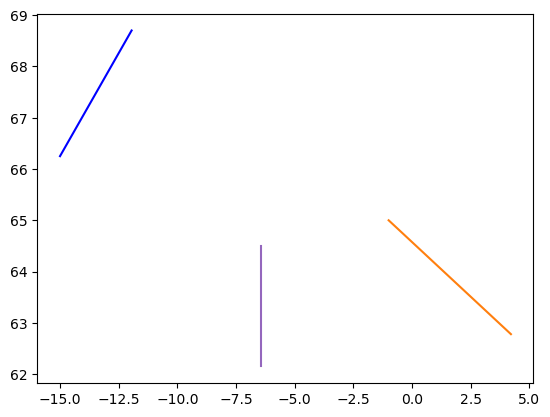

In [50]:
plt.plot([-6.43, -6.43], [62.15, 64.5], color='tab:purple', label='N section')
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
plt.plot([-15, -11.95], [66.25, 68.7], color='blue', label='EIC section');

In [36]:
heat_map_all = compute_probability(ds_orig)

In [16]:
Svinoy_all = filter_trajectories(ds_Svinoy, ds_orig)

In [18]:
EIC_all = filter_trajectories(ds_EIC, ds_orig)
N_all = filter_trajectories(ds_N, ds_orig)

In [20]:
heat_map_svinoy = compute_probability(Svinoy_all['traj_line'])

In [21]:
heat_map_EIC = compute_probability(EIC_all['traj_line'])
heat_map_N = compute_probability(N_all['traj_line'])

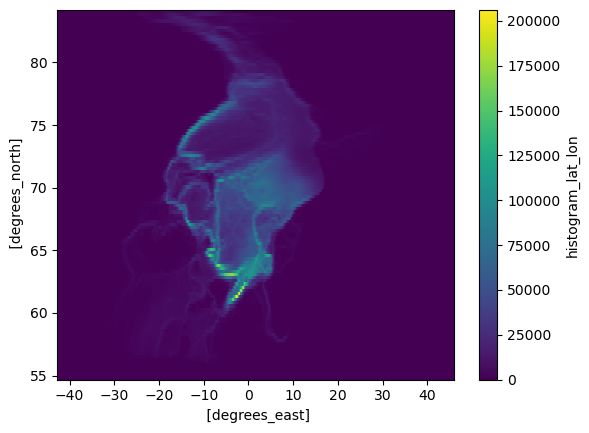

In [22]:
heat_map_svinoy.plot();

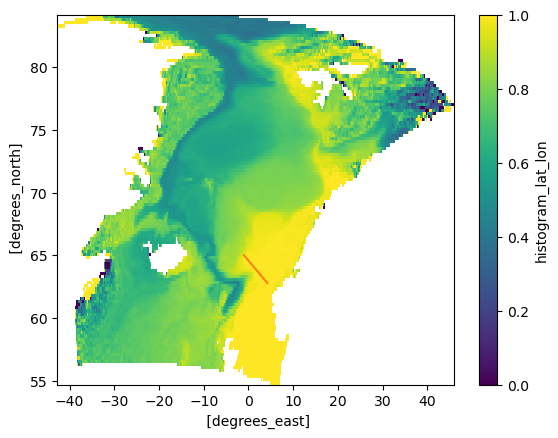

In [26]:
(heat_map_svinoy/heat_map_all).plot()
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section');

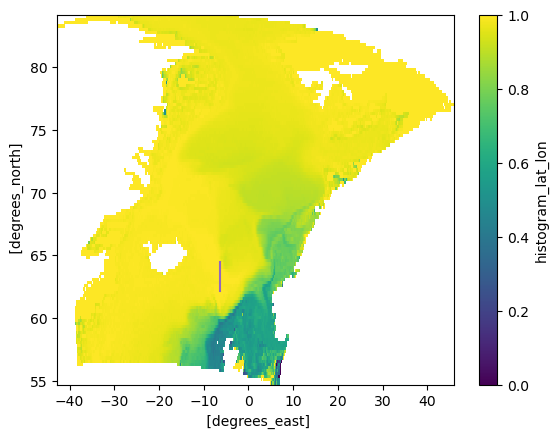

In [27]:
(heat_map_N/heat_map_all).plot()
plt.plot([-6.43, -6.43], [62.15, 64.5], color='tab:purple', label='N section');

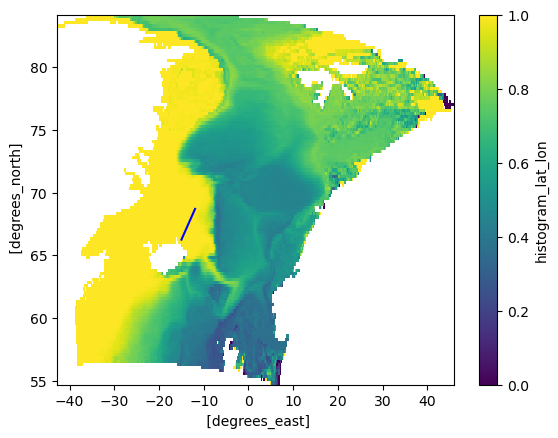

In [28]:
(heat_map_EIC/heat_map_all).plot()
plt.plot([-15, -11.95], [66.25, 68.7], color='blue', label='EIC section');

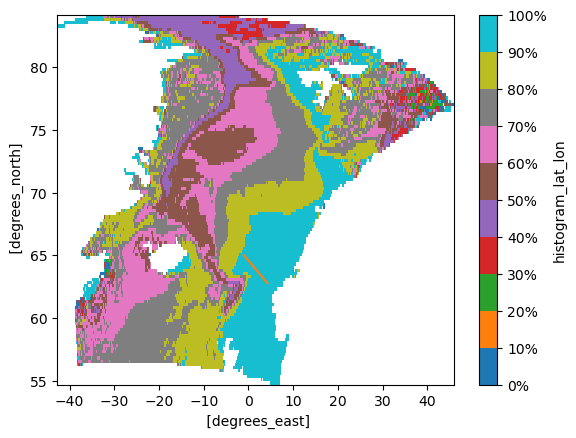

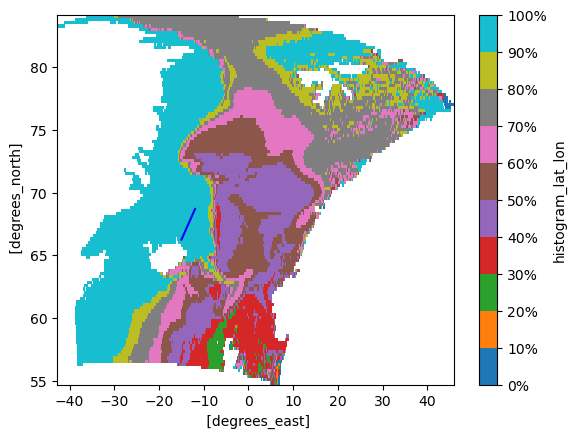

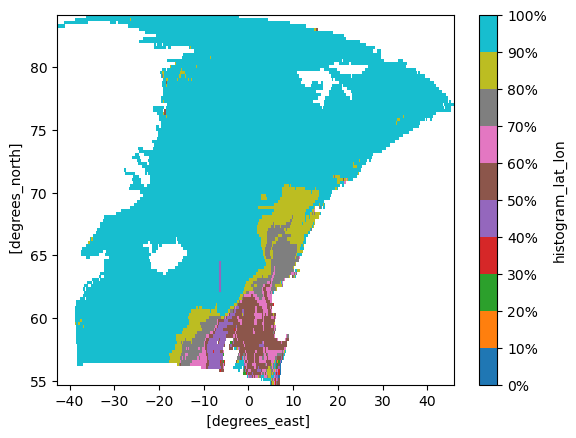

In [48]:
import matplotlib.ticker as ticker

heatmap = ((heat_map_svinoy / heat_map_all) * 100).plot(cmap='tab10')
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
# Adjust colorbar ticks
cbar = heatmap.colorbar
cbar.set_ticks(np.arange(0, 100 + 10, 10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

heatmap = ((heat_map_EIC / heat_map_all) * 100).plot(cmap='tab10')
plt.plot([-15, -11.95], [66.25, 68.7], color='blue', label='EIC section')
# Adjust colorbar ticks
cbar = heatmap.colorbar
cbar.set_ticks(np.arange(0, 100 + 10, 10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

heatmap = ((heat_map_N / heat_map_all) * 100).plot(cmap='tab10')
plt.plot([-6.43, -6.43], [62.15, 64.5], color='tab:purple', label='N section')
cbar = heatmap.colorbar
cbar.set_ticks(np.arange(0, 100 + 10, 10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

In [29]:
# nans_none = (ds_N_line['temp'].isnull() & ds_Svinoy_line['temp'].isnull()).sum(dim='obs')
# traj_not = ds_orig.sel(trajectory=(nans_none == 20075))

# heat_map_obs_non = xhist(traj_not.lat, traj_not.lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="")

# heat_map_obs_unique_non = (heat_map_obs_non > 0).sum(dim='trajectory')

# heat_map_probability_non_cp = heat_map_obs_unique_non.compute()


In [22]:
heat_map_overflows = compute_probability(ds_overflows)

In [23]:
Svinoy_overflows = filter_trajectories(ds_Svinoy_overflows, ds_overflows)

In [24]:

EIC_overflows = filter_trajectories(ds_EIC_overflows, ds_overflows)
N_overflows = filter_trajectories(ds_N_overflows, ds_overflows)



In [29]:
def rechunk_lat_lon(ds):
    """
    Rechunk latitude and longitude data from the given xarray dataset.

    Parameters:
    ds (xarray.Dataset): The input dataset containing 'lon' and 'lat' variables.

    Returns:
    tuple: A tuple containing the rechunked longitude and latitude arrays.
    """
    lon_rechunk = rechunk_for_hist(ds['lon'])
    lat_rechunk = rechunk_for_hist(ds['lat'])
    
    return lon_rechunk, lat_rechunk

lon_rechunk, lat_rechunk = rechunk_lat_lon(ds_overflows)[0], rechunk_lat_lon(ds_overflows)[1]
def get_mean_maps(ds,lon_rechunk,lat_rechunk):
    weights = xr.ones_like(ds)
    weighted_sum = xhist(lon_rechunk, lat_rechunk, bins=[lon_bins, lat_bins], weights=ds, dim=["obs", "trajectory"])
    counts = xhist(lon_rechunk, lat_rechunk, bins=[lon_bins, lat_bins], weights=weights, dim=["obs", "trajectory"])
    mean_temp = weighted_sum / counts
    return mean_temp



In [32]:
# converting the age from nano seconds 

hours_to_days=0.0416667
hours_to_months=0.00136986
hours_to_years=0.000114155
time_conversion = hours_to_days
velocity_conversion = 1852 * 60 #multiply the value of the V field with 1852 * 60 (the number of meters in 1 degree of latitude)

In [61]:
Svinoy_mean_age_overflows = get_mean_maps(Svinoy_overflows['traj_line'].age,
                                          rechunk_lat_lon(Svinoy_overflows['traj_line'])[0],
                                          rechunk_lat_lon(Svinoy_overflows['traj_line'])[1]).compute()

In [67]:
EIC_mean_age_overflows = get_mean_maps(EIC_overflows['traj_line'].age,
                                       rechunk_lat_lon(EIC_overflows['traj_line'])[0],
                                       rechunk_lat_lon(EIC_overflows['traj_line'])[1]).compute()

N_mean_age_overflows = get_mean_maps(N_overflows['traj_line'].age,
                                     rechunk_lat_lon(N_overflows['traj_line'])[0],
                                     rechunk_lat_lon(N_overflows['traj_line'])[1]).compute()

In [52]:
land_mask_ones = mesh_mask.tmask.isel(t=0,z=0)

In [137]:
Svinoy_mean_temp_overflows = get_mean_maps(Svinoy_overflows['traj_line'].temp,
                                          rechunk_lat_lon(Svinoy_overflows['traj_line'])[0],
                                          rechunk_lat_lon(Svinoy_overflows['traj_line'])[1]).compute()

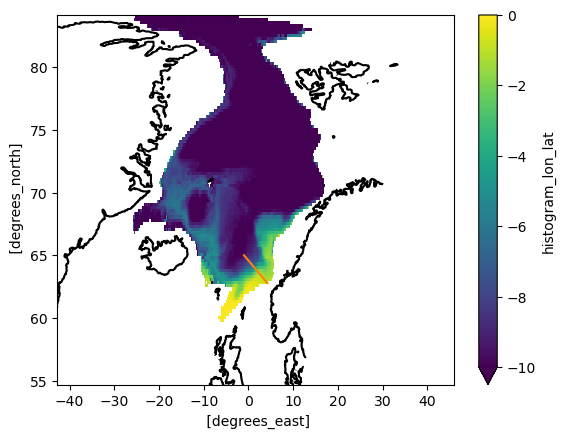

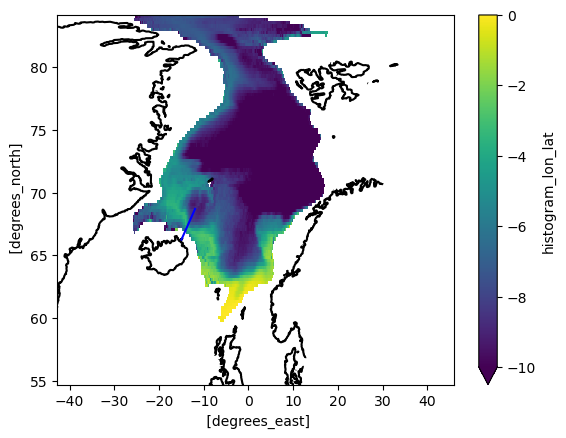

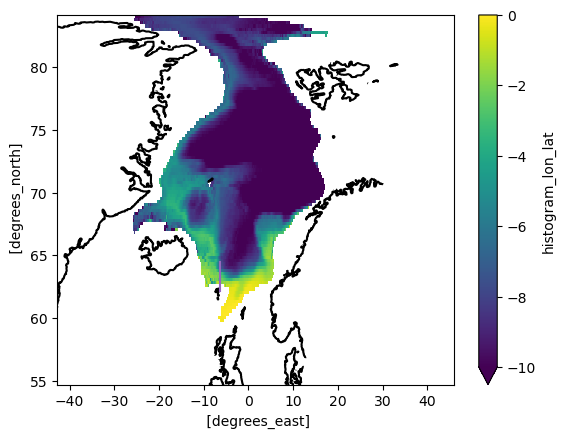

In [72]:

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = (Svinoy_mean_age_overflows.T*hours_to_years).plot(cmap='viridis', vmin=-10,vmax=0)
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
cbar = heatmap.colorbar
#cbar.set_ticks(np.arange(0, 100 + 10, 10))
#cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = (EIC_mean_age_overflows.T*hours_to_years).plot(cmap='viridis', vmin=-10,vmax=0)
plt.plot([-15, -11.95], [66.25, 68.7], color='blue', label='EIC section')
cbar = heatmap.colorbar
#cbar.set_ticks(np.arange(0, 100 + 10, 10))
#cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = (N_mean_age_overflows.T*hours_to_years).plot(cmap='viridis', vmin=-10,vmax=0)
plt.plot([-6.43, -6.43], [62.15, 64.5], color='tab:purple', label='N section')
cbar = heatmap.colorbar
plt.show()


In [181]:
def compute_heat_maps(ds):
    """
    Compute heat maps and probabilities from the given dataset.

    Parameters:
    ds (xarray.Dataset): The input dataset containing latitude, longitude, and trajectory data.
    lat_bins (array-like): The bins for latitude.
    lon_bins (array-like): The bins for longitude.

    Returns:
    dict: A dictionary containing the computed heat maps and probabilities.
    """
    
    # Compute heat map of observations
    heat_map_obs = xhist(ds.lat, ds.lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="")
    
    # Compute heat map of trajectories
    heat_map_traj = xhist(ds.lat, ds.lon, bins=[lat_bins, lon_bins], bin_dim_suffix="")
    
    # Summing particle counts over the whole integration period
    heat_map_obs_sum = heat_map_traj
    
    # Dividing by the total number of particle counts for all bins
    total_counts = heat_map_obs_sum.sum()
    heat_map_normalized = heat_map_obs_sum / total_counts

    # Calculate the total number of observations
    total_observations = ds.obs.size

    # Calculate the probability for each bin
    heat_map_probability_obs = (heat_map_obs / total_observations) * 100

    # Summing particle counts over the whole integration period, considering each particle only once per bin
    heat_map_obs_unique = (heat_map_obs > 0).sum(dim='trajectory')

    # Dividing by the total number of particles to get the probability for each bin
    total_particles = ds.trajectory.size
    heat_map_probability = (heat_map_obs_unique / total_particles) * 100

    # Compute the results
    heat_map_normalized_comp = heat_map_normalized#.compute()
    heat_map_compute = heat_map_obs.sum(dim='trajectory')#.compute()
    heat_map_probability_compute = heat_map_probability.compute()

    return {
        'heat_map_normalized': heat_map_normalized_comp,
        'heat_map_compute': heat_map_compute,
        'heat_map_probability': heat_map_probability_compute,
        'heat_map_probability_obs': heat_map_probability_obs
    }



In [90]:

print('percent of trajectories from deeper flows = ', 
      (N_overflows['traj_line'].trajectory.size+EIC_overflows['traj_line'].trajectory.size+Svinoy_overflows['traj_line'].trajectory.size)/ds_orig.trajectory.size*100,
      '%')

percent of trajectories from deeper flows =  71.8645323134411 %


In [149]:
EIC_overflows['traj_not_line'].trajectory.size + EIC_overflows['traj_line'].trajectory.size

168397

In [151]:
Svinoy_overflows['traj_not_line'].trajectory.size #+ EIC_overflows['traj_line'].trajectory.size

87086

In [152]:
Svinoy_overflows['traj_line'].trajectory.size

81311

In [150]:
ds_overflows.trajectory.size

168397

In [153]:
EIC_overflow_heat_map_NOT_LINE = compute_heat_maps(EIC_overflows['traj_not_line'])

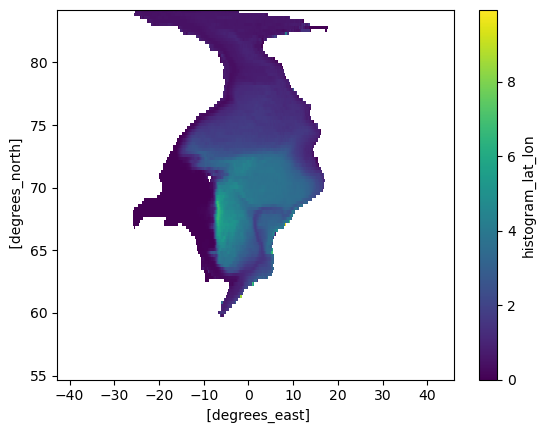

In [ ]:
(EIC_overflow_heat_map_NOT_LINE['heat_map_probability']/EIC_overflow_heat_map['heat_map_probability']).plot();

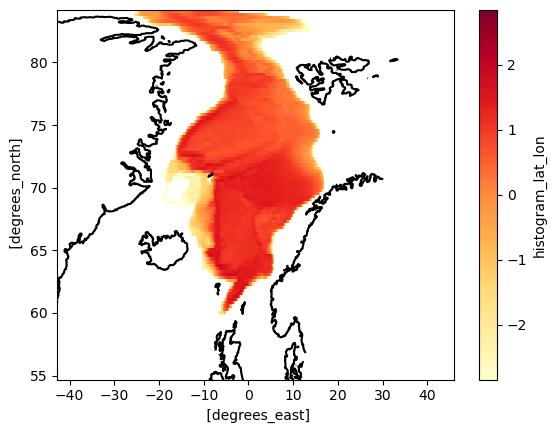

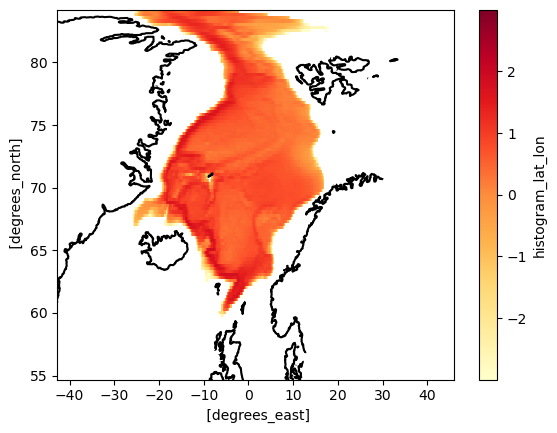

In [155]:
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(EIC_overflow_heat_map_NOT_LINE['heat_map_probability']).plot(cmap='YlOrRd')
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(EIC_overflow_heat_map['heat_map_probability']).plot(cmap='YlOrRd')
plt.show()

In [100]:
EIC_overflow_heat_map = compute_heat_maps(EIC_overflows['traj_line'])

In [106]:
N_overflow_heat_map = compute_heat_maps(N_overflows['traj_line'])

In [93]:
Svinoy_overflow_heat_map = compute_heat_maps(Svinoy_overflows['traj_line'])

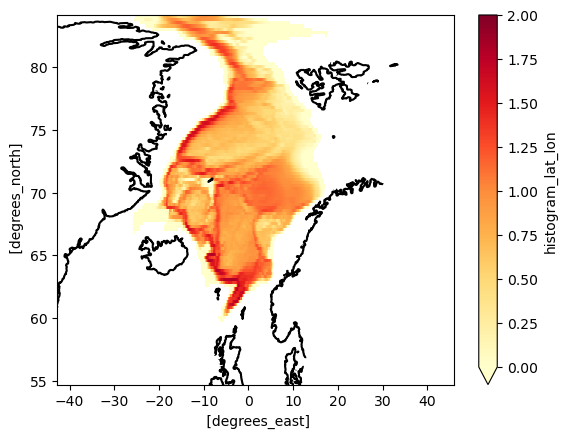

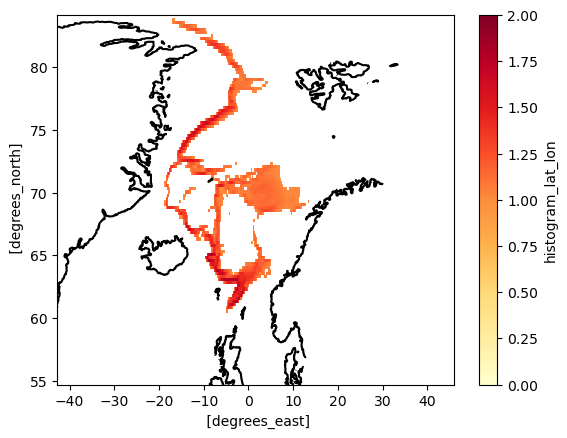

In [145]:
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(N_overflow_heat_map['heat_map_probability']).plot(cmap='YlOrRd',vmin=0,vmax=2)
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(N_overflow_heat_map['heat_map_probability']).where(np.log10(N_overflow_heat_map['heat_map_probability']) > 1).plot(cmap='YlOrRd',vmin=0,vmax=2)
plt.show()

In [120]:
# x = np.log10(EIC_overflow_heat_map['heat_map_probability'])

# x.where(x>1).plot(cmap='YlOrRd',vmin=0,vmax=2)

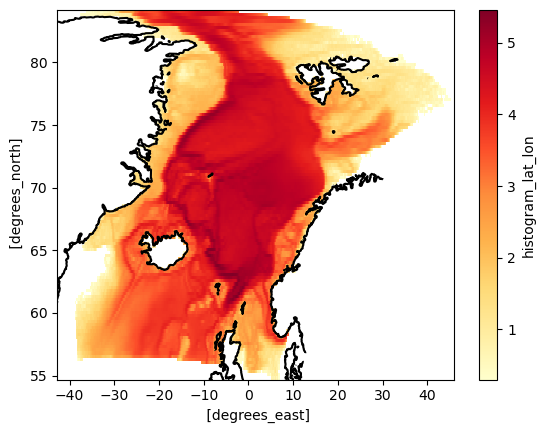

In [144]:
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(heat_map_all).where(np.log10(heat_map_all) > 0).plot(cmap='YlOrRd')
plt.show()


# np.log10(heat_map_all).where(np.log10(heat_map_all) > 4.5).plot(cmap='YlOrRd')
# plt.show()

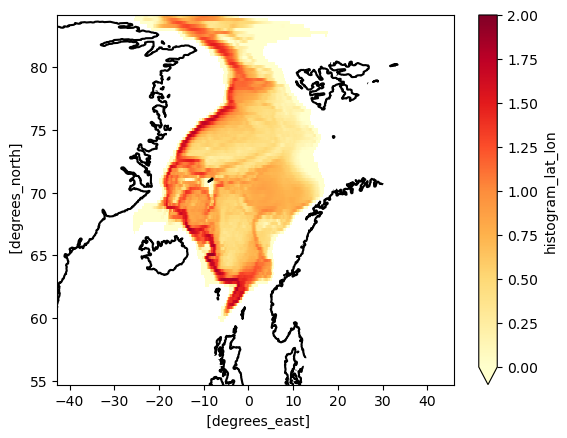

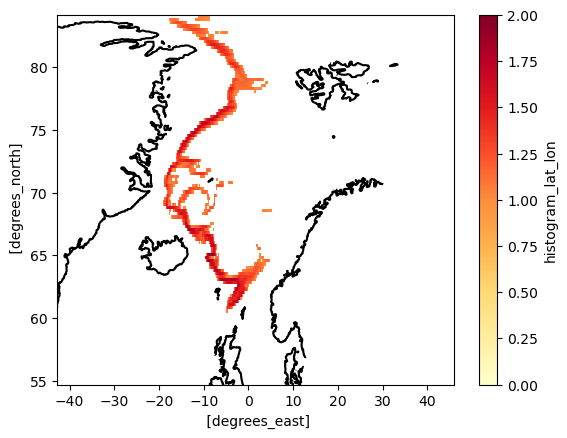

In [143]:
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(EIC_overflow_heat_map['heat_map_probability']).plot(cmap='YlOrRd',vmin=0,vmax=2)
plt.show() 


plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(EIC_overflow_heat_map['heat_map_probability']).where(np.log10(EIC_overflow_heat_map['heat_map_probability']) > 1).plot(cmap='YlOrRd',vmin=0,vmax=2)
plt.show()


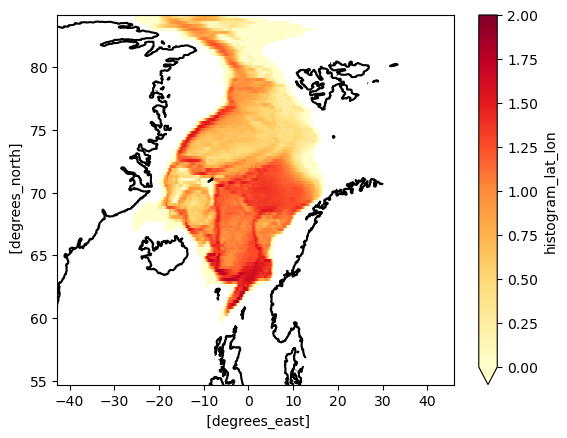

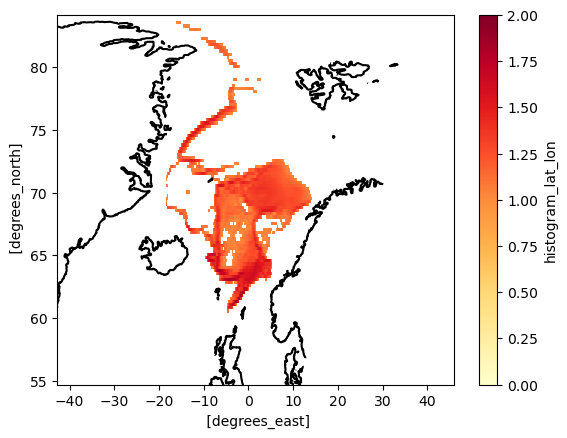

In [125]:
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(Svinoy_overflow_heat_map['heat_map_probability']).plot(cmap='YlOrRd',vmin=0,vmax=2)
plt.show()

plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
np.log10(Svinoy_overflow_heat_map['heat_map_probability']).where(np.log10(Svinoy_overflow_heat_map['heat_map_probability']) > 1).plot(cmap='YlOrRd',vmin=0,vmax=2)
plt.show()


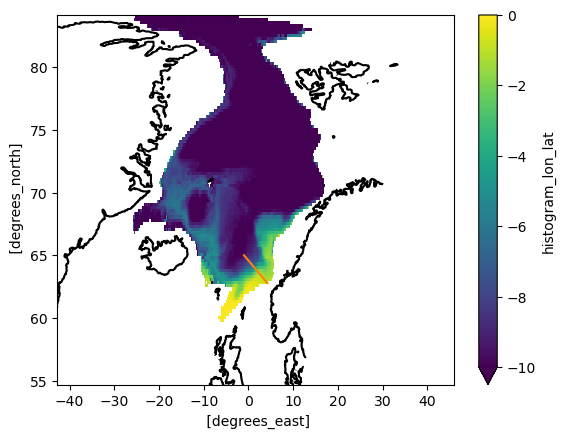

In [123]:
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.tmask.isel(t=0,z=0),levels=0,colors='k')
heatmap = (Svinoy_mean_age_overflows.T*hours_to_years).plot(cmap='viridis', vmin=-10,vmax=0)
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
cbar = heatmap.colorbar
#cbar.set_ticks(np.arange(0, 100 + 10, 10))
#cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

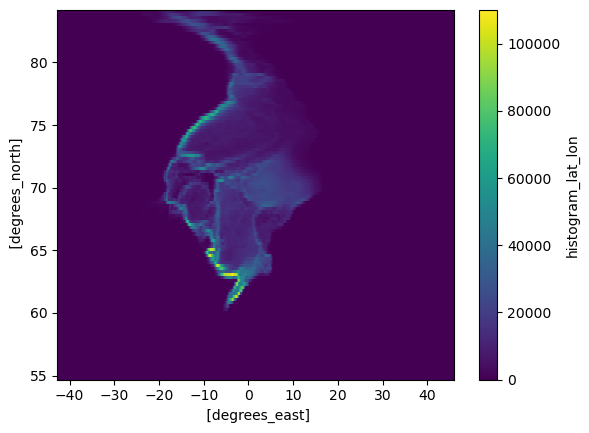

In [64]:
heat_map_overflows.plot()

In [66]:
#@heat_map_svinoy_overflows.plot()

In [33]:
heat_map_svinoy_overflows = compute_probability(Svinoy_overflows['traj_line'])
heat_map_EIC_overflows = compute_probability(EIC_overflows['traj_line'])
heat_map_N_overflows = compute_probability(N_overflows['traj_line'])


In [56]:
# lon_rechunk = rechunk_for_hist(ds['lon'])
# lat_rechunk = rechunk_for_hist(ds['lat'])

def rechunk_lat_lon(ds):
    """
    Rechunk latitude and longitude data from the given xarray dataset.

    Parameters:
    ds (xarray.Dataset): The input dataset containing 'lon' and 'lat' variables.

    Returns:
    tuple: A tuple containing the rechunked longitude and latitude arrays.
    """
    lon_rechunk = rechunk_for_hist(ds['lon'])
    lat_rechunk = rechunk_for_hist(ds['lat'])
    
    return lon_rechunk, lat_rechunk

In [37]:
lon, lat = heat_map_all.lon,heat_map_all.lat
def plot_particle_maps(ds_binned, cmap, cbar_label, title, ticks,
                       vmin=None, vmax=None):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
    ax.set_extent([-40, 20, 55, 85], crs=ccrs.PlateCarree())
    
    # Plot the bathymetry data on the orthographic map
    pcolormesh = ax.pcolormesh(
        mesh_mask.nav_lon, mesh_mask.nav_lat, land_mask, 
        transform=ccrs.PlateCarree(), cmap='binary')
    
    # Determine vmin and vmax if not provided
    if vmin is None:
        vmin = np.min(ds_binned)
    if vmax is None:
        vmax = np.max(ds_binned)

    # Plot the particle density
    x = ax.pcolormesh(lon, lat, ds_binned, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    cbar = plt.colorbar(x)
    cbar.set_label(cbar_label)
    cbar.set_ticks(ticks)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
    gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    ax.plot([5.5, -1], [62.24, 65.], color='tab:pink', label='Svinoy section', transform=ccrs.PlateCarree())
    ax.plot([-6.43, -6.43], [62.15, 64.5], color='tab:green', label='N section', transform=ccrs.PlateCarree())
    ax.plot([-15, -11.95], [66.25, 68.7], color='blue', label='LN section', transform=ccrs.PlateCarree())
    ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
    ax.set_title(title)
    plt.show()

In [59]:
lon_rechunk, lat_rechunk = rechunk_lat_lon(ds_overflows)[0], rechunk_lat_lon(ds_overflows)[1]

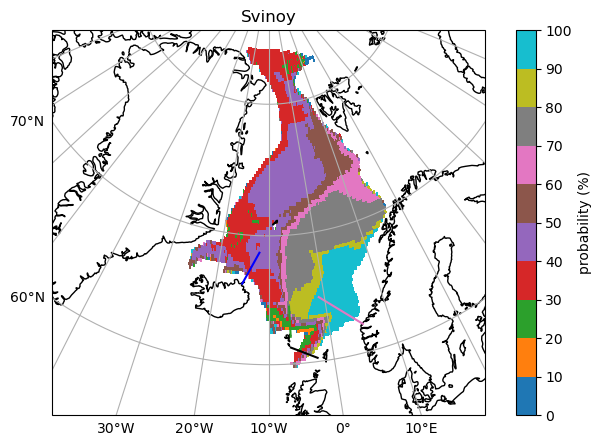

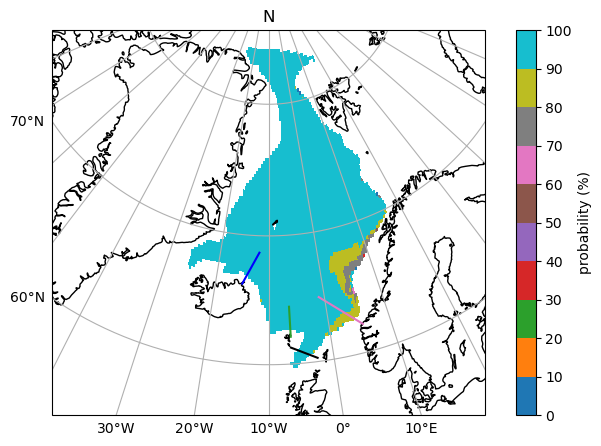

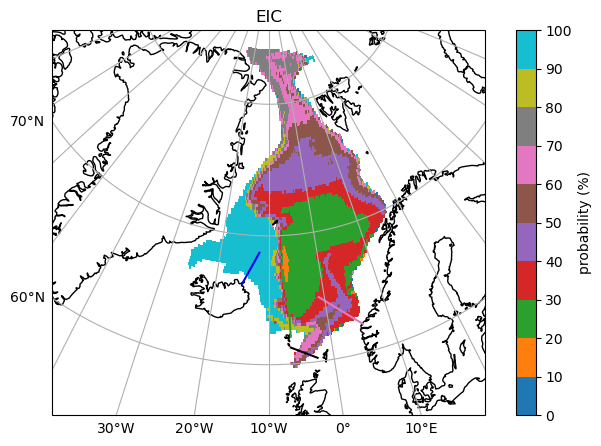

In [ ]:
plot_particle_maps((heat_map_svinoy_overflows / heat_map_overflows) * 100, 'tab10',
                   'probability (%)', 'Svinoy', np.arange(0, 100 + 10, 10),vmin=0, vmax=100)

plot_particle_maps((heat_map_N_overflows / heat_map_overflows) * 100, 'tab10',
                   'probability (%)', 'N', np.arange(0, 100 + 10, 10),vmin=0, vmax=100)

plot_particle_maps((heat_map_EIC_overflows / heat_map_overflows) * 100, 'tab10',
                     'probability (%)', 'EIC', np.arange(0, 100 + 10, 10),vmin=0, vmax=100)

# probability for a particle to cross that section over any time. 

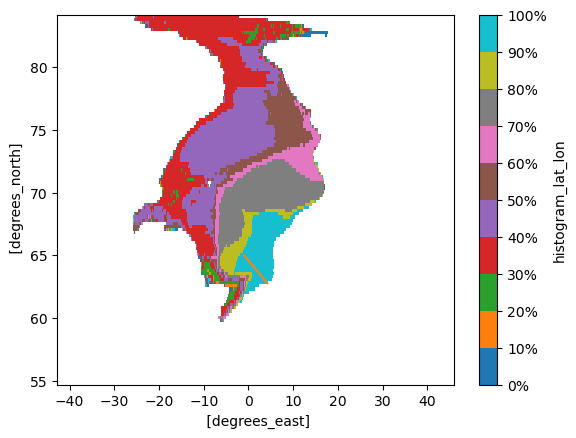

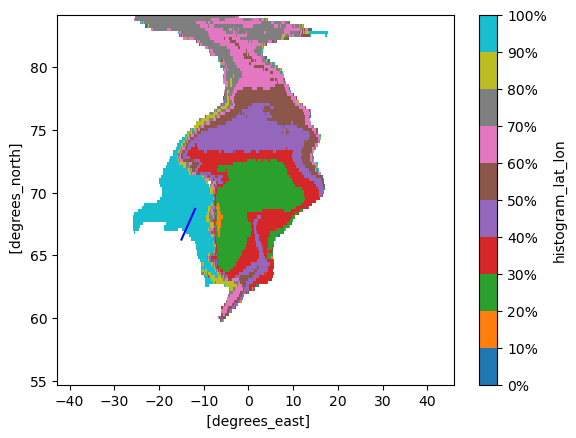

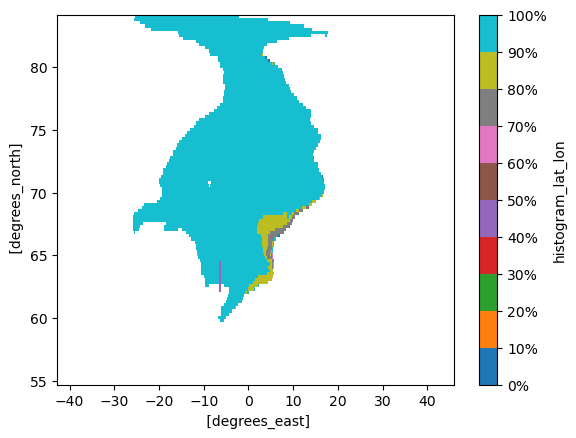

In [49]:
import matplotlib.ticker as ticker

heatmap = ((heat_map_svinoy_overflows / heat_map_overflows) * 100).plot(cmap='tab10')
plt.plot([4.21, -1], [62.78, 65.], color='tab:orange', label='Svinoy section')
# Adjust colorbar ticks
cbar = heatmap.colorbar
cbar.set_ticks(np.arange(0,100+10,10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

heatmap = ((heat_map_EIC_overflows / heat_map_overflows) * 100).plot(cmap='tab10')
plt.plot([-15, -11.95], [66.25, 68.7], color='blue', label='EIC section')
# Adjust colorbar ticks
cbar = heatmap.colorbar
cbar.set_ticks(np.arange(0,100+10,10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

heatmap = ((heat_map_N_overflows / heat_map_overflows) * 100).plot(cmap='tab10')
plt.plot([-6.43, -6.43], [62.15, 64.5], color='tab:purple', label='N section')
cbar = heatmap.colorbar
cbar.set_ticks(np.arange(0,100+10,10))
cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.show()

In [184]:
def compute_probability(traj_line, traj_not_line):
    # Compute heat maps for both crossing and not crossing trajectories
    heat_map_obs_line = xhist(traj_line.lat, traj_line.lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="")
    heat_map_obs_not_line = xhist(traj_not_line.lat, traj_not_line.lon, bins=[lat_bins, lon_bins], dim=['obs'], bin_dim_suffix="")
    
    # Normalize by the number of trajectories in each category
    total_traj_line = traj_line.trajectory.size
    total_traj_not_line = traj_not_line.trajectory.size
    
    heat_map_probability_line = (heat_map_obs_line > 0).sum(dim='trajectory') / total_traj_line
    heat_map_probability_not_line = (heat_map_obs_not_line > 0).sum(dim='trajectory') / total_traj_not_line

    return heat_map_probability_line.compute(), heat_map_probability_not_line.compute()

In [185]:
Svinoy_overflows = filter_trajectories(ds_Svinoy_overflows, ds_overflows)

In [186]:
Svinoy_test = compute_probability(Svinoy_overflows['traj_line'], Svinoy_overflows['traj_not_line'])

In [195]:
N_test = compute_probability(N_overflows['traj_line'], N_overflows['traj_not_line'])


In [215]:
testing_heat_map_N_not_line = compute_heat_maps( N_overflows['traj_not_line'])

Task exception was never retrieved
future: <Task finished name='Task-3855905' coro=<Client._gather.<locals>.wait() done, defined at /gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

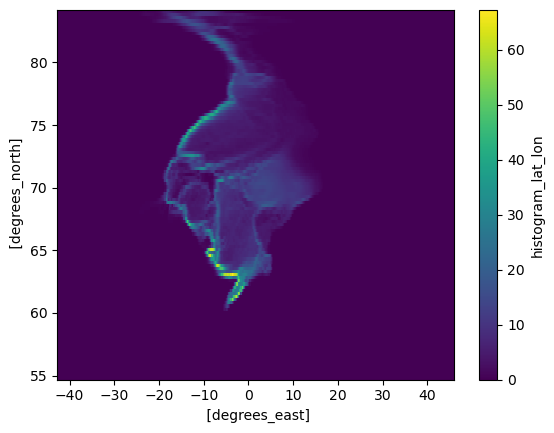

In [196]:
(N_test[0]*100).plot();

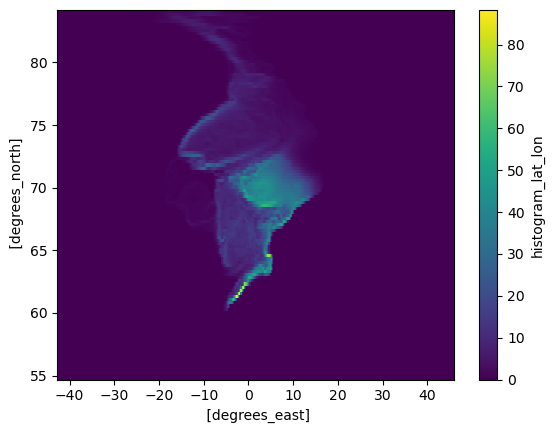

In [197]:
(N_test[1]*100).plot();

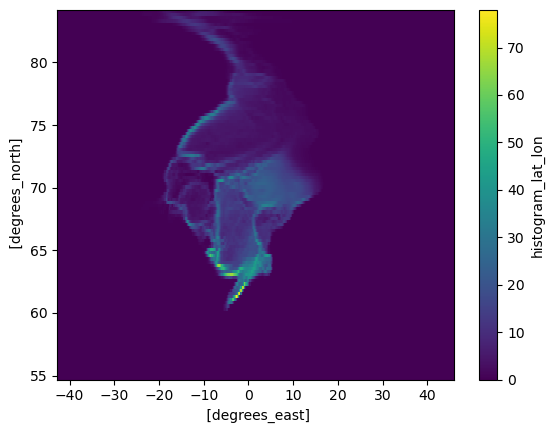

In [193]:
(Svinoy_test[0]*100).plot();

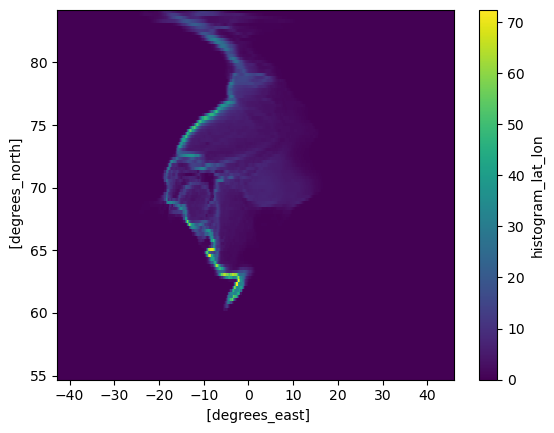

In [194]:
(Svinoy_test[1]*100).plot();

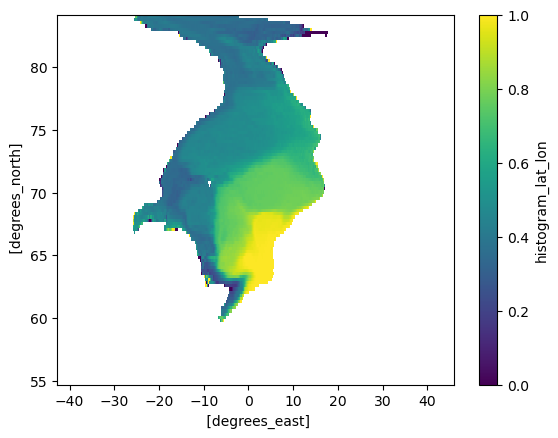

In [206]:
(Svinoy_test[0]/(Svinoy_test[1]+Svinoy_test[0])).plot(vmin=0,vmax=1);

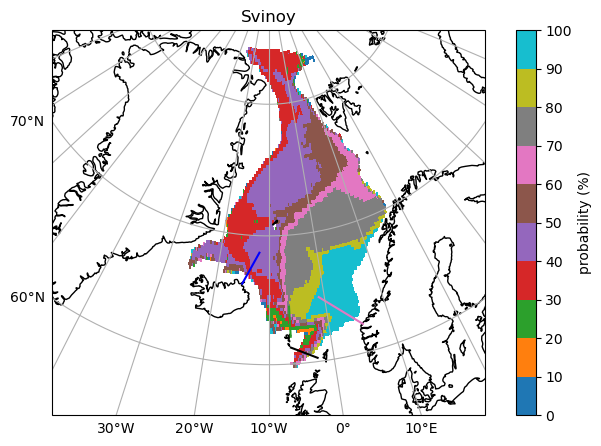

In [207]:
# gets the same! 
plot_particle_maps((Svinoy_test[0]/(Svinoy_test[1]+Svinoy_test[0])) * 100, 'tab10',
                   'probability (%)', 'Svinoy', np.arange(0, 100 + 10, 10), vmin=0, vmax=100)


In [162]:
# Filter trajectories
filtered_trajectories = filter_trajectories(ds_Svinoy_overflows, ds_overflows)
traj_line = filtered_trajectories['traj_line']
traj_not_line = filtered_trajectories['traj_not_line']

# Compute probabilities
heat_map_probability_line, heat_map_probability_not_line = compute_probability(traj_line, traj_not_line)



In [169]:
heat_map_probability_line = heat_map_probability_line.sum(dim='trajectory').compute()
heat_map_probability_not_line = heat_map_probability_not_line.sum(dim='trajectory').compute()

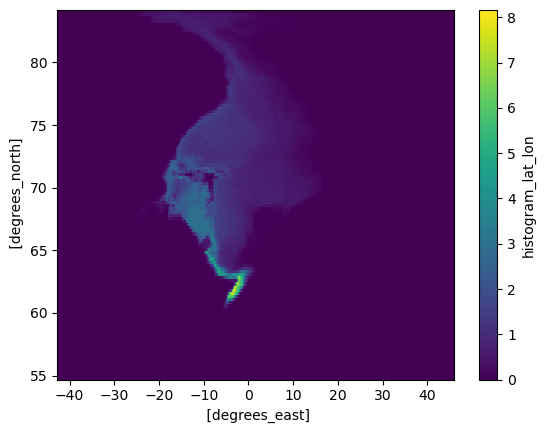

In [173]:
heat_map_probability_not_line.plot();

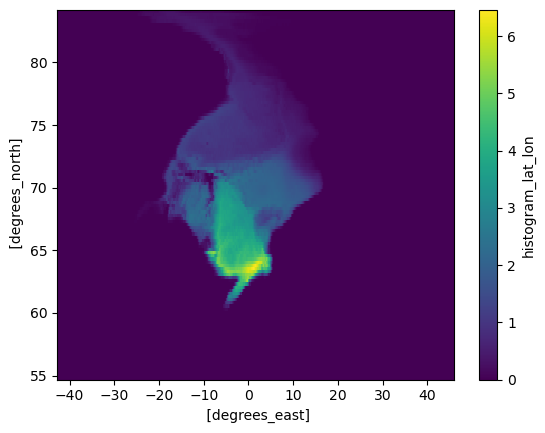

In [175]:
heat_map_probability_line.plot();

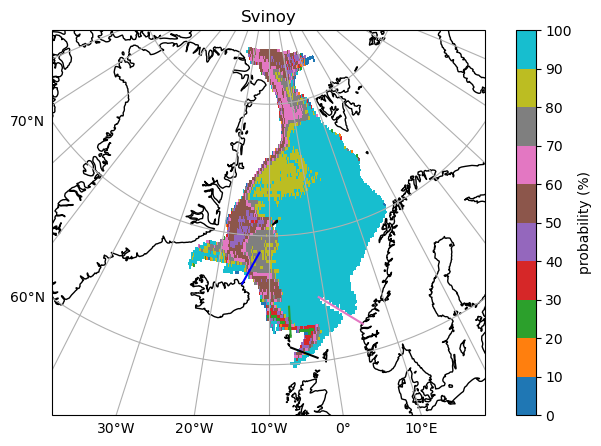

In [171]:
# Plotting the results
plot_particle_maps((heat_map_probability_line / heat_map_probability_not_line) * 100, 'tab10',
                   'probability (%)', 'Svinoy', np.arange(0, 100 + 10, 10), vmin=0, vmax=100)
